In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import equinox as eqx
import optax
from tqdm.autonotebook import tqdm

/tmp/ipykernel_1383203/6392105.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import pdequinox as pdeqx

In [3]:
NUM_POINTS = 64
NUM_SAMPLES = 1000
DOMAIN_EXTENT = 5.0
# Grid excludes the two Dirichlet points
grid = jnp.linspace(0, DOMAIN_EXTENT, NUM_POINTS + 2)[1:-1]
dx = grid[1] - grid[0]

A = (
    jnp.diag(jnp.ones(NUM_POINTS - 1), -1)
    - 2 * jnp.diag(jnp.ones(NUM_POINTS), 0)
    + jnp.diag(jnp.ones(NUM_POINTS - 1), 1)
)
A = A / dx**2


def solve_poisson(f):
    return jnp.linalg.solve(A, -f)


def create_discontinuity(key):
    limit_1_key, limit_2_key = jax.random.split(key)
    lower_limit = jax.random.uniform(
        limit_1_key, (), minval=0.2 * DOMAIN_EXTENT, maxval=0.4 * DOMAIN_EXTENT
    )
    upper_limit = jax.random.uniform(
        limit_2_key, (), minval=0.6 * DOMAIN_EXTENT, maxval=0.8 * DOMAIN_EXTENT
    )

    discontinuity = jnp.where((grid >= lower_limit) & (grid <= upper_limit), 1.0, 0.0)

    return discontinuity


primary_key = jax.random.PRNGKey(0)
keys = jax.random.split(primary_key, NUM_SAMPLES)
force_fields = jax.vmap(create_discontinuity)(keys)
displacement_fields = jax.vmap(solve_poisson)(force_fields)

# Add a singleton channel axis
displacement_fields = displacement_fields[:, None, :]
force_fields = force_fields[:, None, :]

2024-04-08 14:49:40.558571: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
force_fields.shape, displacement_fields.shape

((1000, 1, 64), (1000, 1, 64))

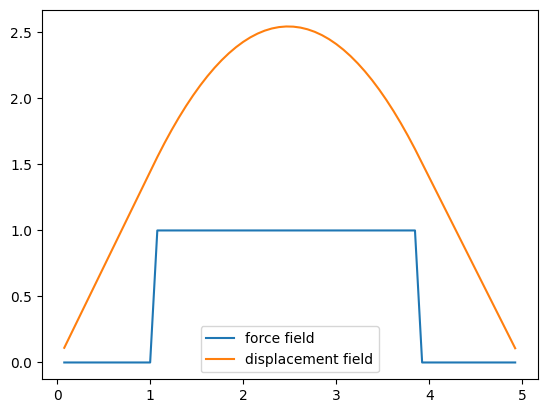

In [5]:
plt.plot(grid, force_fields[0, 0], label="force field")
plt.plot(grid, displacement_fields[0, 0], label="displacement field")
plt.legend()

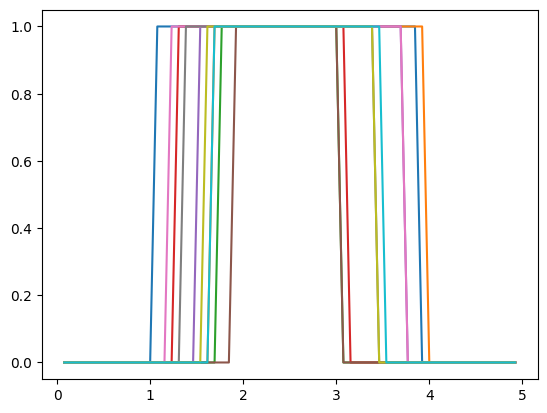

In [6]:
plt.plot(grid, force_fields[:10, 0].T);

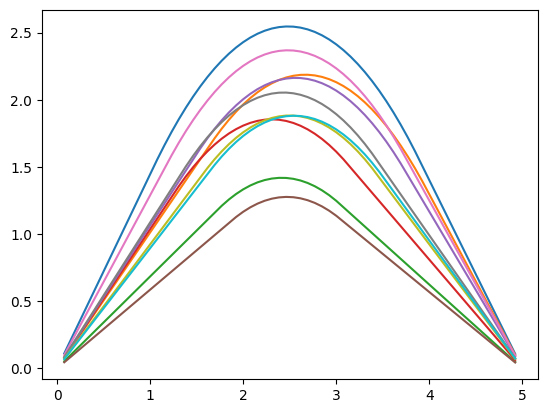

In [7]:
plt.plot(grid, displacement_fields[:10, 0].T);

In [8]:
# 4:1 train test split
split_index = NUM_SAMPLES // 5 * 4
train_x, test_x = force_fields[:split_index], force_fields[split_index:]
train_y, test_y = displacement_fields[:split_index], displacement_fields[split_index:]

In [9]:
# Training loop

poisson_solver_unet = pdeqx.arch.ClassicUNet(
    1,
    1,
    1,
    hidden_channels=32,
    num_levels=2,
    activation=jax.nn.relu,
    key=jax.random.PRNGKey(0),
    boundary_mode="dirichlet",
)

parameter_count = pdeqx.count_parameters(poisson_solver_unet)
print("Number of parameters: ", parameter_count)

optimizer = optax.adam(3e-4)
opt_state = optimizer.init(eqx.filter(poisson_solver_unet, eqx.is_array))


def loss_fn(model, x, y):
    y_pred = jax.vmap(model)(x)
    mse = jnp.mean(jnp.square(y_pred - y))
    return mse


@eqx.filter_jit
def update_fn(model, state, x, y):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, x, y)
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss


loss_history = []
shuffle_key = jax.random.PRNGKey(151)
for epoch in tqdm(range(100)):
    shuffle_key, subkey = jax.random.split(shuffle_key)

    for batch in pdeqx.dataloader((train_x, train_y), batch_size=32, key=subkey):
        poisson_solver_unet, opt_state, loss = update_fn(
            poisson_solver_unet,
            opt_state,
            *batch,
        )
        loss_history.append(loss)

Number of parameters:  189633


  0%|          | 0/100 [00:00<?, ?it/s]

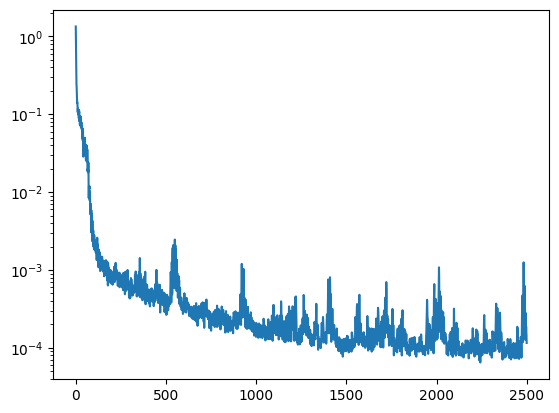

In [11]:
plt.semilogy(loss_history)

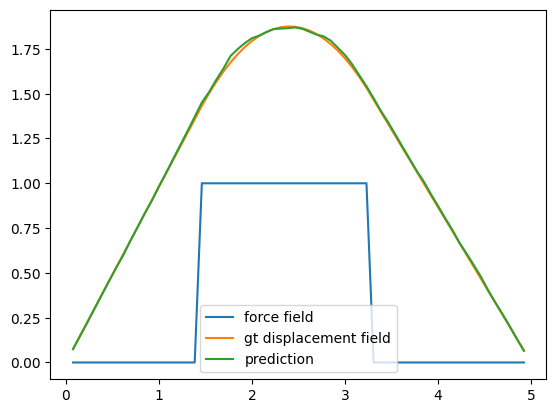

In [12]:
BATCH_I = 5
plt.plot(grid, test_x[BATCH_I, 0], label="force field")
plt.plot(grid, test_y[BATCH_I, 0], label="gt displacement field")
plt.plot(grid, poisson_solver_unet(test_x[BATCH_I])[0], label="prediction")
plt.legend()

In [13]:
def normalized_l2_norm(pred, ref):
    diff_norm = jnp.linalg.norm(pred - ref)
    ref_norm = jnp.linalg.norm(ref)
    return diff_norm / ref_norm

In [14]:
test_predictions = jax.vmap(poisson_solver_unet)(test_x)

In [15]:
test_errors = jax.vmap(normalized_l2_norm)(test_predictions, test_y)

In [16]:
test_errors.shape

(200,)

In [17]:
jnp.mean(test_errors), jnp.std(test_errors)

(Array(0.00817455, dtype=float32), Array(0.00171203, dtype=float32))